In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score,KFold
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from lightgbm import plot_importance
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("./data/mushroom_train.csv", encoding="utf-8")
test_df = pd.read_csv("./data/mushroom_test.csv", encoding="utf-8")

In [3]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)
df

,mushroom_id,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,p,x,s,n,t,p,f,c,n,...,s,w,w,p,w,o,p,k,s,u
1,1,e,x,s,y,t,a,f,c,b,...,s,w,w,p,w,o,p,n,n,g
2,2,e,b,s,w,t,l,f,c,b,...,s,w,w,p,w,o,p,n,n,m
3,3,p,x,y,w,t,p,f,c,n,...,s,w,w,p,w,o,p,k,s,u
4,4,e,x,s,g,f,n,f,w,b,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,8119,NaN,k,s,n,f,n,a,c,b,...,s,o,o,p,o,o,p,b,c,l
8120,8120,NaN,x,s,n,f,n,a,c,b,...,s,o,o,p,n,o,p,b,v,l
8121,8121,NaN,f,s,n,f,n,a,c,b,...,s,o,o,p,o,o,p,b,c,l
8122,8122,NaN,k,y,n,f,y,f,c,n,...,k,w,w,p,w,o,e,w,v,l


<BarContainer object of 23 artists>

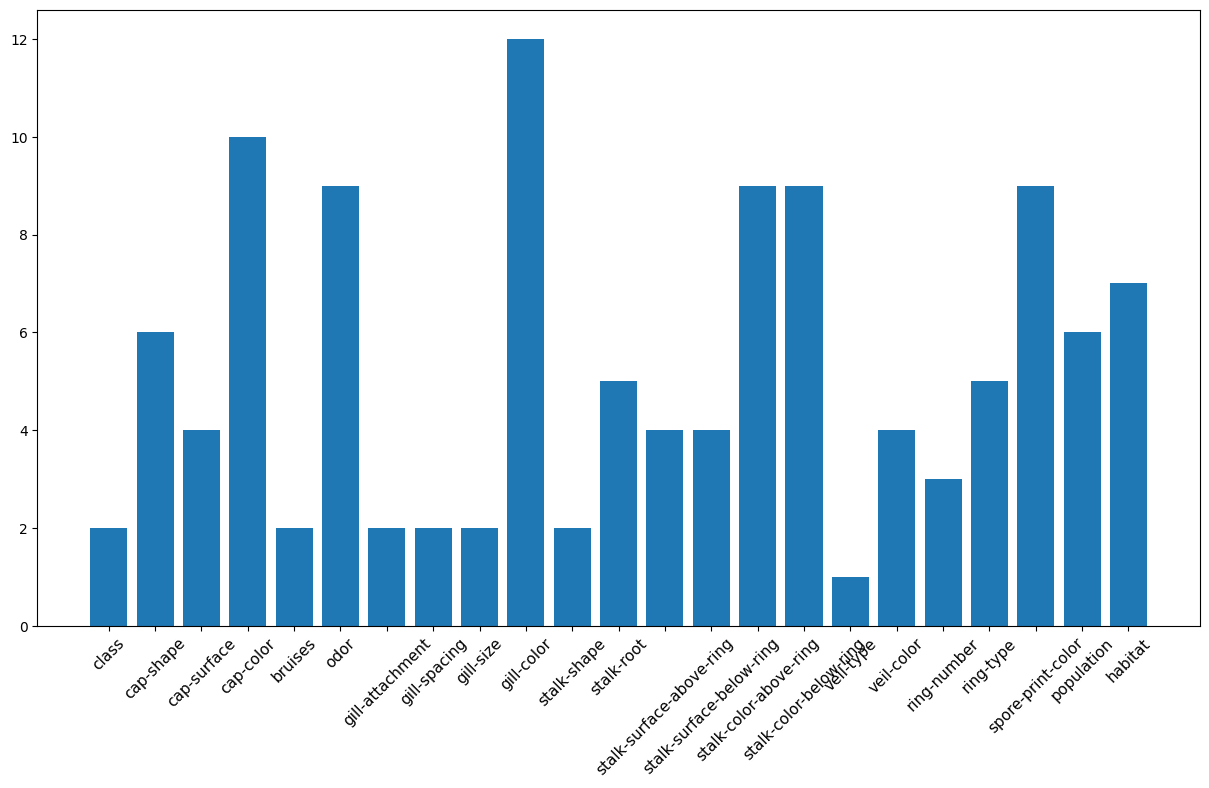

In [46]:
df_bar = df.select_dtypes('object').nunique()

plt.figure(figsize=(15,8))
plt.xticks(rotation=45,fontsize=11)
plt.bar(df_bar.index,df_bar.values)

In [47]:
df = pd.get_dummies(data=df, columns=['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
           'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
           'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
           'stalk-surface-below-ring', 'stalk-color-above-ring',
           'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
           'ring-type', 'spore-print-color', 'population', 'habitat'], drop_first=True)
df = df*1
df

,mushroom_id,class_p,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,2,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,3,1,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,8119,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8120,8120,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0
8121,8121,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8122,8122,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0


In [48]:
train_df = df[:6500]
test_df = df[6500:]

In [49]:
test_df = test_df.drop(["class_p"],axis=1)
x_train = train_df.drop(['mushroom_id','class_p'],axis=1)
y_train = train_df['class_p']
x_test = test_df.drop(['mushroom_id'],axis=1)

In [50]:
stratified_kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=1234)

In [51]:
model = lgb.LGBMClassifier()


param_grid = { "n_estimators":[400],"max_depth":[3,5],
    "num_leaves":[10],
    "subsample": [0.8]}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=stratified_kf
)

In [ ]:
grid_search.fit(x_train, y_train)

In [53]:
grid_search.best_params_

{'max_depth': 3, 'n_estimators': 400, 'num_leaves': 10, 'subsample': 0.8}

In [54]:
grid_search.best_score_

1.0

In [55]:
model = lgb.LGBMClassifier(**grid_search.best_params_)

In [ ]:
model.fit(x_train,y_train)

In [59]:
y_test_pred = model.predict(x_test)
test_df["class"] = y_test_pred
test_df["class"] = test_df["class"].replace([1,0],["p","e"])
test_df[["mushroom_id","class"]].to_csv("./data/submission_mushroom_13.csv", index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<Figure size 1500x1000 with 0 Axes>

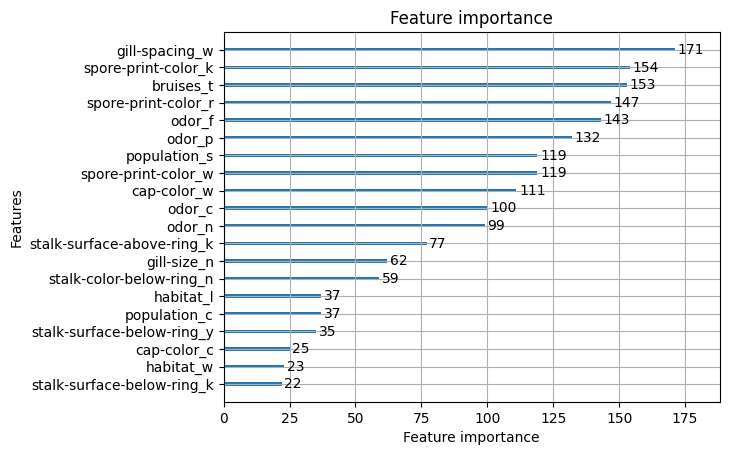

In [14]:
plt.figure(figsize=(15,10))
plot_importance(model,max_num_features = 20)

In [60]:
len(test_df[test_df["class"] =="p"])*100/len(test_df["class"])

68.7807881773399

In [68]:
test_df['class'].nunique()

2

In [74]:
counts = test_df['class'].value_counts()
total = len(test_df)
percent = counts/total * 100

<Axes: xlabel='class'>

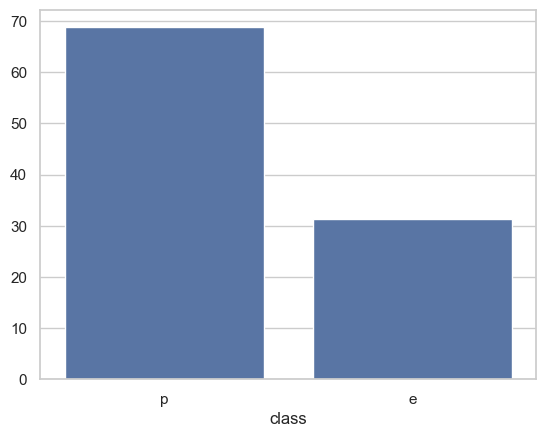

In [77]:
sns.set(style='whitegrid')
sns.barplot(
    x=percent.index,
    y=percent.values
)

In [2]:
#끝